<h1 align="center"> In-Depth Analysis </h1>
<h4 align="left">Capstone Project 1: Home Loan Credibility Assessment </h4>

Bhaskar Das <br>
Springboard Data Science Career Track, May 2019 cohort <br>

### Import Libraries

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualisations
%matplotlib inline
sns.set_style( 'white' )
# Set the style of plots
plt.style.use('fivethirtyeight')

# pandas column display 
pd.set_option('display.max_columns', 122)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import gc

# Modelling Algorithms
from lightgbm import LGBMClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor    

### Machine Learning

In this project, we will work on the home loan credibility assessment data. By analyzing the data, we have found out that the data shows an imbalanced class problem, that contains far more records of the loan paid instances than loans not repaid. Therefore, we have explored the undersampling method on the loan paid samples to prepare the data for the machine learning models.

Out of 122 features, 67 of them have the missing values, and most of them have more than 50%. Therefore, I have used three methods to deal with them, one, delete all the rows with missing values, two, use SimpleImputer to fill the missing values, and three, use machine learning models to deal with the missing values.

Most of the machine learning model cannot deal with categorical variables. Therefore, we will encode these variables using the One-Hot Encoding, as numbers before handing them off to the model. There are two main ways to carry out this process:

We have split the data into two parts, 70% for training and 30% for testing. 

## Method 1: 
Here, we will prepare the data by deleting rows with the mission values and undersampling the loan repaid data.
### Data Preparation

In [2]:
df = pd.read_csv("./Data_Files/application_train.csv")
df0v1 = df[df['TARGET']==0]
df1v1 = df[df['TARGET']==1]
print('Original sample shape: ', df.shape, ' - 0 shape: ', df0v1.shape, ' - 1 shape: ', df1v1.shape)

# Drop rows with null values. Missing value treatment.
df.dropna(inplace=True)
df0v1 = df[df['TARGET']==0]
df1v1 = df[df['TARGET']==1]
print('Sample shape (Null Row removed): ', df.shape, ' - 0 shape: ', df0v1.shape, ' - 1 shape: ', df1v1.shape)

# Under sampling 0s
df0v2 = df[df['TARGET']==0].head(1500) #75% 0s and 25% 1s 
df1v2 = df[df['TARGET']==1].head(500)
frames = [df0v2, df1v2]
df = pd.concat(frames)
print('Under sampling shape: ', df.shape, ' - 0 shape: ', df0v2.shape, ' - 1 shape: ', df1v2.shape)

Original sample shape:  (307511, 122)  - 0 shape:  (282686, 122)  - 1 shape:  (24825, 122)
Sample shape (Null Row removed):  (8602, 122)  - 0 shape:  (8076, 122)  - 1 shape:  (526, 122)
Under sampling shape:  (2000, 122)  - 0 shape:  (1500, 122)  - 1 shape:  (500, 122)


In [3]:
labels = df['TARGET']

# Remove ID variables
df.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

# one-hot encoding of categorical variables
df = pd.get_dummies(df)

# train_test_split
trainx, testx, trainy, testy = train_test_split(df, labels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1400, 228) (600, 228) (1400,) (600,)


### Model Building

In [4]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=200,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(trainx, trainy, eval_set=[(trainx, trainy), (testx, testy)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))
    

eval(testx, testy, 0.3)    

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.832389	training's binary_logloss: 0.431374	valid_1's auc: 0.711236	valid_1's binary_logloss: 0.523666
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.832389	training's binary_logloss: 0.431374	valid_1's auc: 0.711236	valid_1's binary_logloss: 0.523666

Confusion_matrix:  
 [[314 126]
 [ 66  94]]

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       440
           1       0.43      0.59      0.49       160

    accuracy                           0.68       600
   macro avg       0.63      0.65      0.63       600
weighted avg       0.72      0.68      0.69       600


ROC-AUC score of the model:   0.7112357954545454


## Method 2:
We will prepare the data by deleting rows with mission values, undersampling the loan repaid, and dropping columns using multicollinearity analysis.
### Data Preparation

In [5]:
df = pd.read_csv("./Data_Files/application_train.csv")
df0v1 = df[df['TARGET']==0]
df1v1 = df[df['TARGET']==1]
print('Original sample shape: ', df.shape, ' - 0 shape: ', df0v1.shape, ' - 1 shape: ', df1v1.shape)

# Drop rows with null values. Missing value treatment.
df.dropna(inplace=True)
df0v1 = df[df['TARGET']==0]
df1v1 = df[df['TARGET']==1]
print('Sample shape (Null Row removed): ', df.shape, ' - 0 shape: ', df0v1.shape, ' - 1 shape: ', df1v1.shape)

# Under sampling 0s
df0v2 = df[df['TARGET']==0].head(1500) #75% 0s and 25% 1s 
df1v2 = df[df['TARGET']==1].head(500)
frames = [df0v2, df1v2]
df = pd.concat(frames)
print('Under sampling shape: ', df.shape, ' - 0 shape: ', df0v2.shape, ' - 1 shape: ', df1v2.shape)

Original sample shape:  (307511, 122)  - 0 shape:  (282686, 122)  - 1 shape:  (24825, 122)
Sample shape (Null Row removed):  (8602, 122)  - 0 shape:  (8076, 122)  - 1 shape:  (526, 122)
Under sampling shape:  (2000, 122)  - 0 shape:  (1500, 122)  - 1 shape:  (500, 122)


In [6]:
labels = df['TARGET']

# Remove ID variables
df.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

# one-hot encoding of categorical variables
df = pd.get_dummies(df)

### Multicollinearity

In [7]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            #print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
            #      '\' at index: ' + str(maxloc))
            del variables[maxloc]
            gc.collect()
            dropped = True

    return X.iloc[:, variables]

train_data = calculate_vif_(df)
train_data.head(2)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,COMMONAREA_AVG,LIVINGAPARTMENTS_AVG,BASEMENTAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,NONLIVINGAPARTMENTS_MODE,LANDAREA_MEDI,NONLIVINGAREA_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,...,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
71,103500.0,573628.5,24435.0,0.009657,-15406,-892,-341.0,-4176,22.0,1,1,0,1,0,0,2.0,2,18,0,0,0,0,0.270766,0.707126,0.597192,0.9861,0.1080,0.1194,0.1340,0.0403,0.0345,0.3333,0.3750,0.0,0.0000,0.0,2.0,1.0,1.0,-2053.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
124,202500.0,260725.5,16789.5,0.018850,-16282,-4375,-762.0,-1494,8.0,1,1,0,1,0,0,2.0,2,11,0,0,0,0,0.647045,0.746486,0.739412,0.9801,0.0463,0.0756,0.1038,0.0000,0.2069,0.1667,0.2083,0.0,0.0445,0.0,6.0,0.0,0.0,-1782.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [8]:
# train_test_split
trainx, testx, trainy, testy = train_test_split(train_data, labels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1400, 169) (600, 169) (1400,) (600,)


### Model Building

In [9]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=200, 
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(trainx, trainy, eval_set=[(trainx, trainy), (testx, testy)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))
    

eval(testx, testy, 0.3)    

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.825491	training's binary_logloss: 0.43478	valid_1's auc: 0.715071	valid_1's binary_logloss: 0.522016
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.825491	training's binary_logloss: 0.43478	valid_1's auc: 0.715071	valid_1's binary_logloss: 0.522016

Confusion_matrix:  
 [[312 128]
 [ 67  93]]

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       440
           1       0.42      0.58      0.49       160

    accuracy                           0.68       600
   macro avg       0.62      0.65      0.63       600
weighted avg       0.72      0.68      0.69       600


ROC-AUC score of the model:   0.7150710227272726


## Method 3.
In method 3, we will prepare the data by using the imputation to handle the mission values.
### Data Preparation

In [10]:
df = pd.read_csv("./Data_Files/application_train.csv")

y = df['TARGET']

# Remove ID variables
df.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

# one-hot encoding of categorical variables
df = pd.get_dummies(df)


X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(215257, 244) (92254, 244) (215257,) (92254,)


In [11]:
# Imputation of missing values
imputer = SimpleImputer(strategy = 'mean')

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

print('Training data shape: ', X_train.shape, 'Testing data shape: ', X_test.shape)

Training data shape:  (215257, 244) Testing data shape:  (92254, 244)


In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# Train on the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict_proba(X_test)[:,1]
ypred = []
for i in range (len(y_pred)):
    if y_pred[i] > 0.12:
        ypred.append(0)
    else:
        ypred.append(1)

print('\nConfusion matrix: \n',confusion_matrix(y_test, ypred))
print('\nClassification report: \n',classification_report(y_test, ypred))
print('roc_auc_score (Using predict_proba) = ', roc_auc_score(y_test, y_pred))


Confusion matrix: 
 [[16062 68779]
 [ 2472  4941]]

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.19      0.31     84841
           1       0.07      0.67      0.12      7413

    accuracy                           0.23     92254
   macro avg       0.47      0.43      0.22     92254
weighted avg       0.80      0.23      0.30     92254

roc_auc_score (Using predict_proba) =  0.622820948093455


### Model Building

In [13]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=200, 
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))
    

eval(X_test, y_test, 0.12)    

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.770995	training's binary_logloss: 0.243378	valid_1's auc: 0.753239	valid_1's binary_logloss: 0.247334
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.770995	training's binary_logloss: 0.243378	valid_1's auc: 0.753239	valid_1's binary_logloss: 0.247334

Confusion_matrix:  
 [[70550 14291]
 [ 3664  3749]]

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     84841
           1       0.21      0.51      0.29      7413

    accuracy                           0.81     92254
   macro avg       0.58      0.67      0.59     92254
weighted avg       0.89      0.81      0.84     92254


ROC-AUC score of the model:   0.7532392541750991


From our experiments, we can observe that Method 3 produces the best accuracy. It does not employ undersampling, multicollinearity, or deletion of rows with missing values. Therefore, we will use Method 3 to build our machine learning model. Now, we will find out the machine learning model that works best for our project.

In [14]:
df3 = pd.read_csv("./Data_Files/application_train.csv")
print('Sampling shape: ', df3.shape)

Sampling shape:  (307511, 122)


In [15]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [16]:
df3 = df3[df3['CODE_GENDER'] != 'XNA']

# Categorical features with Binary encode (0 or 1 two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df3[bin_feature], uniques = pd.factorize(df3[bin_feature])

# Categorical features with One-Hot encode
df3, cat_cols = one_hot_encoder(df3)
    
# Outlier Treatment: NaN values for DAYS_EMPLOYED: 365.243 -> nan
df3['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# New features (percentages)
df3['DAYS_EMPLOYED_PERC'] = df3['DAYS_EMPLOYED'] / df3['DAYS_BIRTH']
df3['INCOME_CREDIT_PERC'] = df3['AMT_INCOME_TOTAL'] / df3['AMT_CREDIT']
df3['INCOME_PER_PERSON'] = df3['AMT_INCOME_TOTAL'] / df3['CNT_FAM_MEMBERS']
df3['ANNUITY_INCOME_PERC'] = df3['AMT_ANNUITY'] / df3['AMT_INCOME_TOTAL']
df3['PAYMENT_RATE'] = df3['AMT_ANNUITY'] / df3['AMT_CREDIT']

In [17]:
from sklearn.model_selection import train_test_split

labels3 = df3['TARGET']

# Remove ID variables
df3.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

# one-hot encoding of categorical variables
df3 = pd.get_dummies(df3)

# train_test_split
trainx3, testx3, trainy3, testy3 = train_test_split(df3, labels3, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx3.shape , testx3.shape , trainy3.shape , testy3.shape)

train and test data shape:  (215254, 245) (92253, 245) (215254,) (92253,)


#### Light Gradient Boosting

In [18]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=200,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(trainx3, trainy3, eval_set=[(trainx3, trainy3), (testx3, testy3)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))
    

eval(testx3, testy3, 0.12)    

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.778441	training's binary_logloss: 0.241065	valid_1's auc: 0.757215	valid_1's binary_logloss: 0.246345
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.778441	training's binary_logloss: 0.241065	valid_1's auc: 0.757215	valid_1's binary_logloss: 0.246345

Confusion_matrix:  
 [[70856 13955]
 [ 3613  3829]]

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     84811
           1       0.22      0.51      0.30      7442

    accuracy                           0.81     92253
   macro avg       0.58      0.67      0.60     92253
weighted avg       0.89      0.81      0.84     92253


ROC-AUC score of the model:   0.7572148211583262


In [19]:
# Imputation of missing values
imputer = SimpleImputer(strategy = 'mean')

# Fit on the training data
imputer.fit(trainx3)

# Transform both training and testing data
X_train = imputer.transform(trainx3)
X_test = imputer.transform(testx3)

#### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, trainy3)

y_pred = reg.predict(X_test)
print('Linear Regression: roc_auc_score (Using predict) = ' , roc_auc_score(testy3, y_pred))

Linear Regression: roc_auc_score (Using predict) =  0.7465839697165486


#### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# Train on the training data
log_reg.fit(X_train, trainy3)

y_pred = log_reg.predict_proba(X_test)[:,1]
print('Logistic Regression roc_auc_score (Using predict_proba) = ', roc_auc_score(testy3, y_pred))

Logistic Regression roc_auc_score (Using predict_proba) =  0.627274997423726


#### Ridge Regression

In [21]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, trainy3)

y_pred = ridge.predict(X_test)
print('Ridge Regression: roc_auc_score (Using predict) = ', roc_auc_score(testy3, y_pred))

Ridge Regression: roc_auc_score (Using predict) =  0.746597202421708


#### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, np.ravel(trainy3))

y_pred = forest.predict(X_test)
print('Random Forest: roc_auc_score (Using predict) = ', roc_auc_score(testy3, y_pred))

Random Forest: roc_auc_score (Using predict) =  0.6387905135104288


#### Gradient Boost Regressor

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, np.ravel(trainy3))

y_pred = gbr.predict(X_test)
print('Gradient Boosting: roc_auc_score (Using predict) = ', roc_auc_score(testy3, y_pred))

Gradient Boosting: roc_auc_score (Using predict) =  0.7541132339818492


#### Lasso Regression

In [25]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=42)
lasso.fit(X_train, trainy3)

y_pred = lasso.predict(X_test)
print('Lasso Regression: roc_auc_score (Using predict) = ' , roc_auc_score(testy3, y_pred))

Lasso Regression: roc_auc_score (Using predict) =  0.6315649732588609


#### Decision Tree 

In [26]:
from sklearn import tree

trees = tree.DecisionTreeRegressor(max_depth=6, random_state=42)
trees.fit(X_train, trainy3)

y_pred = trees.predict(X_test)
print('Decision Tree Regression: roc_auc_score (Using predict) = ' , roc_auc_score(testy3, y_pred))

Decision Tree Regression: roc_auc_score (Using predict) =  0.7114294585068995


#### Adaptive Boost Regressor

In [27]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator=trees, random_state=42)
ada.fit(X_train, np.ravel(trainy3))

y_pred = trees.predict(X_test)
print('Adaptive Boost Regressor: roc_auc_score (Using predict) = ' , roc_auc_score(testy3, y_pred))

Adaptive Boost Regressor: roc_auc_score (Using predict) =  0.7114294585068995


In this project, we will use the Light Gradient Boosting to build our machine learning model, which gives the best score.

### Feature Importance

We will study the importance of the features and try to improve the model accordingly.

In [35]:
del df
gc.collect()

df = pd.read_csv("./Data_Files/application_train.csv")

df = df[df['CODE_GENDER'] != 'XNA']

# Categorical features with Binary encode (0 or 1 two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])

# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df)
    
# Outlier Treatment: NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# New features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

Starting LightGBM. Train shape: (307507, 247), test shape: (0, 247)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.776656	training's binary_logloss: 0.241143	valid_1's auc: 0.757533	valid_1's binary_logloss: 0.24808
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.776656	training's binary_logloss: 0.241143	valid_1's auc: 0.757533	valid_1's binary_logloss: 0.24808
Fold  1 AUC : 0.757533
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.775451	training's binary_logloss: 0.242462	valid_1's auc: 0.760145	valid_1's binary_logloss: 0.24361
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.775451	training's binary_logloss: 0.242462	valid_1's auc: 0.760145	valid_1's binary_logloss: 0.24361
Fold  2 AUC : 0.760145
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.776842	training's binary_logloss: 0.240574	valid_1's auc: 0.753178	valid_1's bin

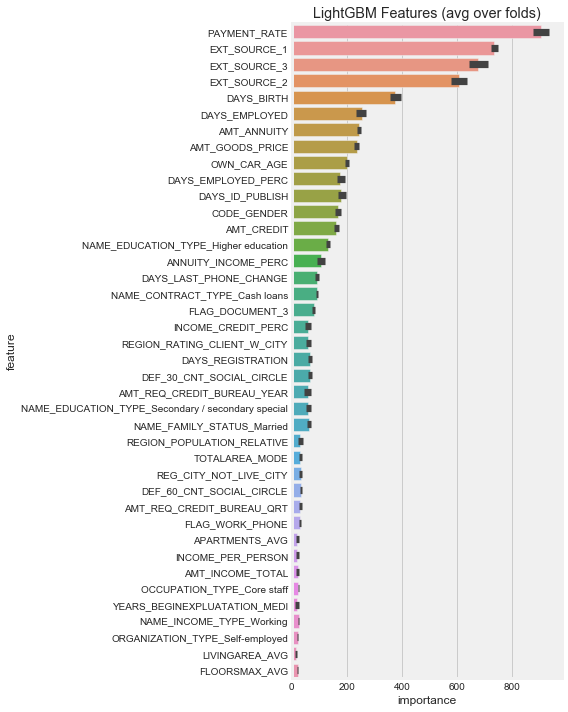

In [42]:
from sklearn.model_selection import KFold, StratifiedKFold

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=42)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    clf = LGBMClassifier(
        nthread=4,
        n_estimators=200,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],  \
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

print('Full AUC score: ', roc_auc_score(train_df['TARGET'], oof_preds))
display_importances(feature_importance_df)

In [43]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

#### ROC AUC Score with top features

In [119]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

y = df["TARGET"]

clf = LGBMClassifier(
            nthread=4,
            n_estimators=200,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

kbestscores = []

for rank in [10, 25, 50, 60, 70, 80, 90, 100, 150, 200, 240, 245]:
    
    X = df[features['feature'][:rank]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],   \
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    ypredict=clf.predict_proba(X_test)[:,1]
    rocscore = roc_auc_score(y_test, ypredict)
    kbestscores.append((rank, rocscore))

for item in kbestscores:
    print("ROC_AUC Score with Only the Top %d Features: %f" % (item[0], item[1]))

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.768279	training's binary_logloss: 0.243848	valid_1's auc: 0.749384	valid_1's binary_logloss: 0.248263
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.768279	training's binary_logloss: 0.243848	valid_1's auc: 0.749384	valid_1's binary_logloss: 0.248263
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.776746	training's binary_logloss: 0.241564	valid_1's auc: 0.756939	valid_1's binary_logloss: 0.24641
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.776746	training's binary_logloss: 0.241564	valid_1's auc: 0.756939	valid_1's binary_logloss: 0.24641
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.778013	training's binary_logloss: 0.24113	valid_1's auc: 0.757502	valid_1's binary_logloss: 0.246284
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.778013	training's b

We can observe from the result that the model with the top 90 features gives us the best accuracy.

## Final Result
Here, we present our final machine learning model with feature engineering.  

In [147]:
from contextlib import contextmanager
from sklearn.model_selection import KFold, StratifiedKFold

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [148]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [149]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./Data_Files/application_train.csv')
    test_df = pd.read_csv('./Data_Files/application_test.csv')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Outlier treatment: NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # New features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [150]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./Data_Files/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./Data_Files/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [151]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./Data_Files/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [152]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./Data_Files/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [153]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./Data_Files/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [154]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./Data_Files/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [177]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    test_df['TARGET'] = sub_preds
    
    roc_auc = roc_auc_score(train_df['TARGET'], oof_preds) 
    fpr, tpr, thresholds = roc_curve(train_df['TARGET'], oof_preds)
    plt.figure()
    plt.plot(fpr, tpr, 'b', label='Light Gradient Boosting (AUC = %0.2f)' % roc_auc, lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1],'r--', lw=2, alpha=.8, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, 'b', label='Light Gradient Boosting (AUC = %0.2f)' % roc_auc, lw=2, alpha=.8)
    
    precision, recall, thresholds = precision_recall_curve(train_df['TARGET'], oof_preds)
    score = average_precision_score(train_df['TARGET'], oof_preds)
    plt.plot(precision, recall, color='g', label='Avg ROC (AUC = %0.2f)' % (score), lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    display_importances(feature_importance_df)
    
    return feature_importance_df

In [180]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

    
def main(debug = False):
    
    num_rows=None
    df = application_train_test(num_rows)
    
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()

    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()

    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    
    feat_importance = kfold_lightgbm(df, num_folds= 2)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.809786	training's binary_logloss: 0.231059	valid_1's auc: 0.775683	valid_1's binary_logloss: 0.242202
[400]	training's auc: 0.838529	training's binary_logloss: 0.21863	valid_1's auc: 0.783716	valid_1's binary_logloss: 0.238818
[600]	training's auc: 0.857298	training's binary_logloss: 0.210549	valid_1's auc: 0.785733	valid_1's binary_logloss: 0.238032
[800]	training's auc: 0.87225	training's binary_logloss: 0.203925	valid_1's auc: 0.786523	valid_1's binary_logloss: 0.237741
[1000]	training's auc: 0.885066	training's binary_logloss: 0.197979	valid_1's auc: 0.78656	valid_1's binary_logloss

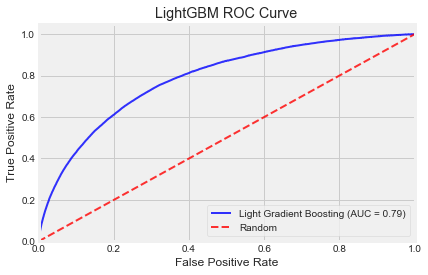

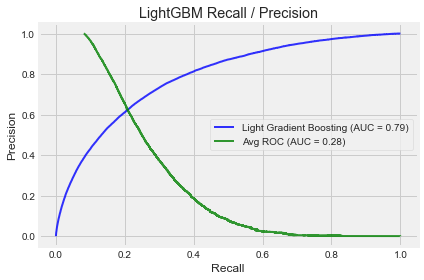

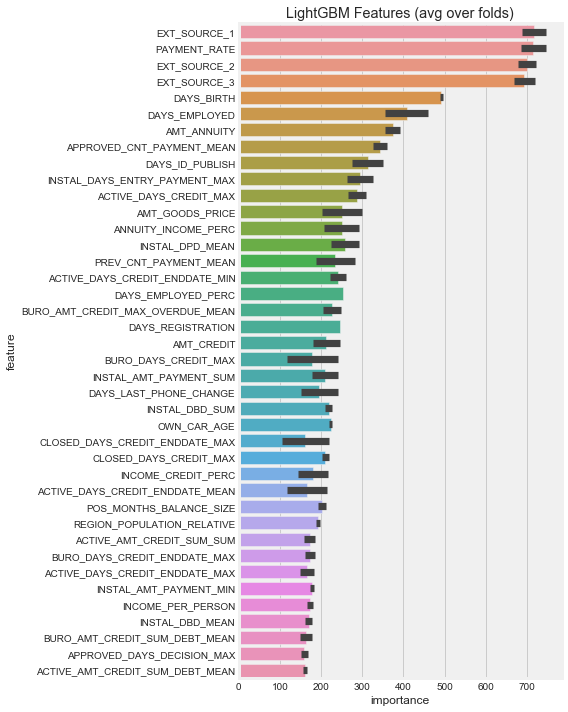

In [181]:
if __name__ == "__main__":
    main()